In [32]:
import numpy as np
import cProfile
import line_profiler
import sys
import csv
import wradlib as wrl
import copy
import warnings
import matplotlib as mpl
from matplotlib import pyplot as plt

from rcit.extrapolation.lagrangian_based_extrapolation import semi_lagrangian_expol
from rcit.motion_cal.rcit_motion import motion_statistic
from rcit.radar_data_io.read_dx_data import read_dwd_dx_radar_data

from rcit.cell_segment.cell_props import get_props_modelled_cell
from rcit.cell_segment.cell_segment_methods import rain_cell_modelling
# from rcit.segmentation.raincell_segment_methods import segment_watershed

from rcit.cell_tracking.raincell_tracking import get_child_rain_cell, get_most_likely_child_rain_cell
from rcit.util.pre_process.pre_process import input_filter
from rcit.verify.veri_categorical import categorical_cal
from rcit.verify.veri_sal import sal_veri

import pysteps.motion as motions
import pysteps.visualization as vis


In [33]:
warnings.filterwarnings('ignore')

In [34]:
# define the color-bar of radar reflectivity, which is suitable for the DWD
def radar_colormap():
    reflectivity_colors = ["#FFFFFF",  # 0 --- 0.02 --- 0.002
                           "#00FFFF",  # 4 --- 0.04 --- 0.003
                           "#43C6DB",  # 8 --- 0.07 --- 0.006
                           "#0000A0",  # 12 --- 0.14 --- 0.012
                           "#00FF00",  # 16 --- 0.27 --- 0.022
                           "#52D017",  # 20 --- 0.52 --- 0.043
                           "#347235",  # 24 --- 0.99 --- 0.082
                           "#FFFF00",  # 28 --- 1.89 --- 0.157
                           "#EAC117",  # 32 --- 3.61 --- 0.301
                           "#F88017",  # 36 --- 6.91 --- 0.576
                           "#FF0000",  # 40 --- 13.21 --- 1.101
                           "#E41B17",  # 44 --- 25.27 --- 2.106
                           "#C11B17",  # 48 --- 48.34 --- 4.029
                           "#F660AB",  # 52 --- 92.48 --- 7.706
                           "#8E35EF",  # 56 --- 176.90 --- 14.741
                           "#000000",  # 60 --- 338.38 --- 28.199
                           ]
    cmap = mpl.colors.ListedColormap(reflectivity_colors)
    return cmap

colormap = radar_colormap()

In [35]:
def write_csv(csv_path, M):
    with open(csv_path, 'w', encoding='utf-8', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerows(M)


In [36]:
# set forecast dataset, totally we choose 27 radar images, the first three is used for global motion calculation, 
# and the next 24 is used for 2-hr nowcasting and correspondly verification
# 2007-05-26, 0-27(00:00); 226-253(18:50); 244-271(20:20); 252-279(21:00). 
# 2008-07-19 192-219(16:00); 
# 2008-07-26 0-27(00:00); 192-219(16:00); 217-244(18:05).

f = open("E:/modeldata/dx_essen/080719/ein_bild.dat")
lines = f.readlines()
lines1 = lines[192:219] 
radar_images = np.full((27, 256, 256), np.nan)
radar_images_filtered = np.full((27, 256, 256), np.nan)
radar_images_intensities = np.full((27, 256, 256), np.nan)
labeled_rain_cells = np.zeros((27, 256, 256), dtype='int')

# property list of identified rain cell
cell_label = []
cell_area = []
cell_center = []
cell_coord = []
cell_bbox = []
cell_bbox_boun = []

# Reflectivity to Intensity for selected parameter threshold 
data_diff_ref = wrl.trafo.idecibel(10)
int_dif = wrl.zr.z_to_r(data_diff_ref, a=256., b=1.42)

data_conv_ref = wrl.trafo.idecibel(30)
int_conv = wrl.zr.z_to_r(data_conv_ref, a=256., b=1.42)

thresh_light_1 = wrl.trafo.idecibel(19)
thresh_light = wrl.zr.z_to_r(thresh_light_1, a=256., b=1.42)

thresh_conv_1 = wrl.trafo.idecibel(46)
thresh_conv = wrl.zr.z_to_r(thresh_conv_1, a=256., b=1.42)


In [37]:
# excuation of segmentation pocedure for the selected radar images
t = 0
for lines2 in lines1:
    line = lines2.split('\n')
    line1 = lines2.split('.ess\n')
    print(line1[0][2:])

    reflectivity, intensity = read_dwd_dx_radar_data("E:/modeldata/dx_essen/080719/" + line[0], 6.96454, 51.40643, 152, 128000)
    origin_ref, filter_ref = input_filter(reflectivity, 'cf')
    origin_intensity, filter_intensity = input_filter(reflectivity, 'cf')
    filter_intensity[np.isnan(filter_intensity)] = 0
    # filter_ref[np.isnan(filter_ref)] = 0
    intensity[np.isnan(intensity)] = 0
    filter_intensity_1 = copy.deepcopy(filter_intensity)
    # filter_ref_1 = copy.deepcopy(filter_ref)

    label_modelled_cell = rain_cell_modelling(filter_intensity, 37, 9, 46)
    # label_modelled_cell = segment_watershed(filter_intensity, 37, 9)

    radar_images[t, :, :] = reflectivity
    radar_images_filtered[t, :, :] = filter_intensity_1
    radar_images_intensities[t, :, :] = intensity
    labeled_rain_cells[t, :, :] = label_modelled_cell


    cell_props, df_cells = get_props_modelled_cell(filter_intensity_1, label_modelled_cell)
    print(df_cells)

    label = [temp[0] for temp in cell_props]
    area = [temp[2] for temp in cell_props]
    coords = [temp[9] for temp in cell_props]
    center = [temp[3] for temp in cell_props]
    bbox = [temp[10] for temp in cell_props]
    bbox_search = [temp[11] for temp in cell_props]

    cell_label.append(label)
    cell_area.append(area)
    cell_coord.append(coords)
    cell_center.append(center)
    cell_bbox.append(bbox)
    cell_bbox_boun.append(bbox_search)

    t += 1


0807191600
    Label  Peak Intensity  Area                                    Center  \
0       1       46.609439     9                              (2.0, 104.0)   
1       2       45.970588    23   (3.1739130434782608, 118.8695652173913)   
2       3       38.610444    32                       (8.8125, 106.53125)   
3       4       44.518164    43    (29.441860465116278, 64.5813953488372)   
4       5       42.790227    35   (29.685714285714287, 48.17142857142857)   
5       6       45.850479   151  (40.980132450331126, 104.58940397350993)   
6       7       44.272107    40                           (68.85, 203.65)   
7       8       52.782030   507   (86.48126232741618, 103.48520710059172)   
8       9       41.491280    58   (84.03448275862068, 131.25862068965517)   
9      10       38.537008    21                              (87.0, 72.0)   
10     11       52.772583   552  (104.43659420289855, 221.70108695652175)   
11     12       40.197774    32                      (96.9375, 12

    Label  Peak Intensity  Area                                    Center  \
0       1       49.385177    45   (4.733333333333333, 123.06666666666666)   
1       2       38.779335    44                 (11.0, 114.4090909090909)   
2       3       44.571212    60                             (30.4, 70.95)   
3       4       47.309910    56  (30.607142857142858, 53.660714285714285)   
4       5       54.206176   149  (44.375838926174495, 115.93959731543625)   
5       6       38.553478    23    (70.1304347826087, 209.82608695652175)   
6       7       54.255655   725    (94.49793103448276, 115.0896551724138)   
7       8       54.417460   214   (89.06542056074767, 219.23831775700936)   
8       9       46.762465   179   (114.3463687150838, 11.983240223463687)   
9      10       57.521370   167  (114.94011976047904, 146.32335329341316)   
10     11       40.066293   138    (119.8840579710145, 40.08695652173913)   
11     12       37.075423     9                              (121.0, 3.0)   

    Label  Peak Intensity  Area                                    Center  \
0       1       46.150517     9                              (33.0, 65.0)   
1       2       42.182376    25                             (45.0, 127.0)   
2       3       40.255116    29   (48.41379310344828, 133.86206896551724)   
3       4       46.286122   181   (89.06077348066299, 133.93370165745856)   
4       5       50.515981   302   (95.22847682119205, 228.26490066225165)   
5       6       53.394604   221   (99.56561085972851, 112.65158371040724)   
6       7       54.775514   496   (111.86290322580645, 144.8991935483871)   
7       8       48.845778   330  (116.98787878787878, 244.01818181818183)   
8       9       39.779377    58  (110.41379310344827, 17.689655172413794)   
9      10       37.131465    18                (118.66666666666667, 28.0)   
10     11       38.558940    36               (121.16666666666667, 13.25)   
11     12       46.784143    87   (121.55172413793103, 55.13793103448276)   

    Label  Peak Intensity  Area                                    Center  \
0       1       41.482241    39    (6.82051282051282, 139.43589743589743)   
1       2       45.509398    43                (25.093023255813954, 58.0)   
2       3       46.480078    60   (30.716666666666665, 70.36666666666666)   
3       4       48.744408    88    (48.67045454545455, 141.3409090909091)   
4       5       39.027981    26    (58.84615384615385, 52.46153846153846)   
5       6       48.866011   405  (107.81975308641975, 240.97283950617285)   
6       7       44.379236    92   (92.31521739130434, 148.56521739130434)   
7       8       43.479877    46   (100.8695652173913, 116.23913043478261)   
8       9       49.243323    62  (104.38709677419355, 124.96774193548387)   
9      10       51.699556   358  (111.60335195530726, 145.50837988826817)   
10     11       38.420982    41   (108.53658536585365, 10.78048780487805)   
11     12       51.439972   114   (106.62280701754386, 250.3421052631579)   

    Label  Peak Intensity  Area                                    Center  \
0       1       47.475440     9                              (2.0, 144.0)   
1       2       40.596670    24   (7.916666666666667, 149.91666666666666)   
2       3       44.954947    45   (26.266666666666666, 68.13333333333334)   
3       4       44.148813    52    (30.03846153846154, 54.82692307692308)   
4       5       42.806958    57    (31.45614035087719, 82.59649122807018)   
5       6       37.683539    30                (51.5, 152.63333333333333)   
6       7       38.384167    33   (90.45454545454545, 171.42424242424244)   
7       8       55.849637   689  (108.00870827285921, 149.73875181422352)   
8       9       47.709986   245  (111.44897959183673, 248.15102040816328)   
9      10       40.646275    35  (110.68571428571428, 22.742857142857144)   
10     11       54.134830   293   (119.22525597269625, 180.5494880546075)   
11     12       37.526945    18               (129.33333333333334, 154.0)   

    Label  Peak Intensity  Area                                    Center  \
0       1       40.082075     9                              (5.0, 151.0)   
1       2       41.044728    75   (6.986666666666666, 161.58666666666667)   
2       3       39.533691    27  (26.185185185185187, 51.407407407407405)   
3       4       45.716284    55   (30.345454545454544, 65.96363636363637)   
4       5       38.967928    28                             (37.5, 114.5)   
5       6       40.006503    36               (48.388888888888886, 172.0)   
6       7       37.590914    15                              (59.4, 72.4)   
7       8       40.574826    35   (94.25714285714285, 169.22857142857143)   
8       9       52.186658   226  (107.45132743362832, 185.37610619469027)   
9      10       52.254518   866   (117.54965357967667, 173.5773672055427)   
10     11       37.011872     9                             (108.0, 52.0)   
11     12       44.818702   117   (111.57264957264957, 141.2136752136752)   

    Label  Peak Intensity  Area                                    Center  \
0       1       41.688149     9                              (26.0, 58.0)   
1       2       43.501539    25                              (27.0, 63.0)   
2       3       47.908184    32                       (28.09375, 76.5625)   
3       4       46.249532    52  (30.057692307692307, 191.23076923076923)   
4       5       46.000779    48             (29.416666666666668, 70.3125)   
5       6       37.681295    16                             (37.5, 126.5)   
6       7       37.201890     9                             (45.0, 171.0)   
7       8       42.306765    52   (49.34615384615385, 182.46153846153845)   
8       9       38.378888    26                             (74.0, 178.5)   
9      10       38.807553    24                           (95.625, 182.0)   
10     11       39.291386    26                             (108.5, 63.0)   
11     12       37.791949    19   (111.42105263157895, 45.89473684210526)   

    Label  Peak Intensity  Area                                    Center  \
0       1       37.061290     9                             (19.0, 191.0)   
1       2       39.962665    63   (24.761904761904763, 63.25396825396825)   
2       3       42.450879    53   (28.471698113207548, 75.66037735849056)   
3       4       37.207729     9                             (31.0, 201.0)   
4       5       48.987480   139   (38.53237410071942, 134.12230215827338)   
5       6       53.127230   116  (39.560344827586206, 174.52586206896552)   
6       7       48.287277   200                           (44.56, 188.83)   
7       8       41.125207    39   (74.23076923076923, 188.84615384615384)   
8       9       37.435910    19  (107.42105263157895, 2.1052631578947367)   
9      10       54.723356   814  (131.82800982800984, 197.73341523341523)   
10     11       42.019103    92  (113.78260869565217, 12.858695652173912)   
11     12       50.327781   134  (121.45522388059702, 224.86567164179104)   

    Label  Peak Intensity  Area                                    Center  \
0       1       45.994632    33                 (21.0, 61.96969696969697)   
1       2       46.882310    42                              (23.5, 75.0)   
2       3       46.721890   162  (40.141975308641975, 146.10493827160494)   
3       4       39.326438    33   (39.57575757575758, 160.57575757575756)   
4       5       52.091784    35  (39.457142857142856, 182.74285714285713)   
5       6       51.875171    22    (41.68181818181818, 184.9090909090909)   
6       7       53.223890    93    (42.81720430107527, 191.2258064516129)   
7       8       49.572497   129    (46.3875968992248, 203.63565891472868)   
8       9       37.289644     9                             (75.0, 199.0)   
9      10       42.135102   119   (106.83193277310924, 7.277310924369748)   
10     11       40.278225    68  (111.95588235294117, 21.073529411764707)   
11     12       55.103075  1050  (132.16380952380953, 206.09142857142857)   

    Label  Peak Intensity  Area                                    Center  \
0       1       45.845346     9                              (21.0, 73.0)   
1       2       46.278174    25                              (25.0, 85.0)   
2       3       41.066004    31  (25.419354838709676, 105.45161290322581)   
3       4       45.398198   141   (38.58156028368794, 152.63829787234042)   
4       5       48.535155   245   (45.66122448979592, 206.75918367346938)   
5       6       43.612973   193    (106.8238341968912, 21.11917098445596)   
6       7       46.259584   417   (115.0863309352518, 226.27817745803358)   
7       8       39.607681   102  (116.16666666666667, 202.47058823529412)   
8       9       40.360296    31   (132.4516129032258, 216.70967741935485)   
9      10       38.089098    38   (133.1578947368421, 229.94736842105263)   
10     11       43.190943    36  (134.63888888888889, 140.02777777777777)   
11     12       48.911437   220  (141.52727272727273, 177.00454545454545)   

    Label  Peak Intensity  Area                                    Center  \
0       1       44.620610    25                              (23.0, 97.0)   
1       2       42.563313    43    (23.86046511627907, 86.02325581395348)   
2       3       47.399261    80                       (26.0375, 116.3375)   
3       4       41.317070    43    (36.7906976744186, 157.65116279069767)   
4       5       39.545374    27  (38.592592592592595, 180.07407407407408)   
5       6       44.681255   193   (43.92227979274612, 210.72538860103626)   
6       7       42.230966    81   (44.45679012345679, 167.88888888888889)   
7       8       38.809584    36               (48.916666666666664, 226.0)   
8       9       42.487240   154  (104.51298701298701, 28.883116883116884)   
9      10       44.332460   302  (121.08609271523179, 242.58278145695365)   
10     11       44.578724   316  (121.42721518987342, 220.11075949367088)   
11     12       40.465451    26  (134.46153846153845, 150.84615384615384)   

    Label  Peak Intensity  Area                                    Center  \
0       1       41.899905     9                             (23.0, 107.0)   
1       2       43.286766    48                            (25.5, 126.25)   
2       3       37.832665    27  (25.925925925925927, 141.59259259259258)   
3       4       38.915722    30  (37.266666666666666, 167.63333333333333)   
4       5       37.118653    15                             (44.4, 213.6)   
5       6       39.879591    76    (45.53947368421053, 174.0921052631579)   
6       7       38.495238    65  (100.53846153846153, 34.707692307692305)   
7       8       38.840789    34    (103.44117647058823, 46.8235294117647)   
8       9       43.221030   310  (126.01935483870967, 234.04193548387096)   
9      10       40.503454    46   (134.8695652173913, 162.54347826086956)   
10     11       45.235574    40                         (143.15, 183.925)   
11     12       50.652001   456   (149.35745614035088, 234.1030701754386)   

    Label  Peak Intensity  Area                                    Center  \
0       1       38.025625    34   (23.61764705882353, 136.91176470588235)   
1       2       37.511007    22                             (24.5, 116.5)   
2       3       48.768365   108   (26.63888888888889, 155.07407407407408)   
3       4       43.351414    47  (29.893617021276597, 177.70212765957447)   
4       5       41.751716    45   (37.86666666666667, 197.55555555555554)   
5       6       44.253771    89  (46.157303370786515, 182.41573033707866)   
6       7       37.777851    22     (96.0909090909091, 44.90909090909091)   
7       8       37.696955    26                             (103.0, 56.5)   
8       9       39.154126    54  (133.92592592592592, 236.83333333333334)   
9      10       44.310282    49    (136.0408163265306, 175.3469387755102)   
10     11       44.877072    41  (144.21951219512195, 193.14634146341464)   
11     12       37.671888    21  (144.23809523809524, 253.14285714285714)   

   Label  Peak Intensity  Area                                    Center  \
0      1       43.239458    34  (22.470588235294116, 151.94117647058823)   
1      2       37.671596    22    (25.09090909090909, 164.9090909090909)   
2      3       40.373186    39  (24.897435897435898, 174.97435897435898)   
3      4       39.055567    36   (29.36111111111111, 186.86111111111111)   
4      5       46.517827    76   (50.86842105263158, 196.55263157894737)   
5      6       40.732859    31   (132.41935483870967, 218.6451612903226)   
6      7       51.314594   243   (167.09053497942386, 237.9506172839506)   

   Orientation  Minor_Axis  Major_Axis  Elliptcity  Mean Intensity  \
0     1.107149    5.133512    9.414705    0.545265       40.165540   
1    -0.785398    4.972652    5.502817    0.903656       35.931184   
2     0.732899    6.445459    7.720788    0.834819       33.803934   
3     1.324541    6.012511    7.638294    0.787154       35.768094   
4     0.725599    9.722833   10.243762   

In [38]:
# Motion Vectors from RCIT algorithm
# pr = cProfile.Profile()
profile = line_profiler.LineProfiler(motion_statistic)# pass the function to the energy analyzer
profile.enable() # start analyzing
# pr.enable()
location_motion_RCIT, motion_RCIT, global_vectors_RCIT = motion_statistic(27, radar_images_filtered, 32, 32, 0.5, 0.5, 5, 5, 0.1)
# pr.disable()
# pr.print_stats()
profile.disable() # stop analyzing
profile.print_stats(sys.stdout) # print results

0
prevailing wind direction is:  [268.48939631] mean speed is:  3.9096842490669492
1
prevailing wind direction is:  [267.11847681] mean speed is:  3.9260951626694407
2
prevailing wind direction is:  [269.82650413] mean speed is:  3.882496860461425
3
prevailing wind direction is:  [302.27646108] mean speed is:  3.842753916544818
4
prevailing wind direction is:  [268.79749165] mean speed is:  3.997620467783984
5
prevailing wind direction is:  [271.03626876] mean speed is:  3.890646148929996
6
prevailing wind direction is:  [270.99494941] mean speed is:  3.9827183688254006
7
prevailing wind direction is:  [278.33914] mean speed is:  4.033944139649724
8
prevailing wind direction is:  [277.36023178] mean speed is:  3.985432262414497
9
prevailing wind direction is:  [281.33438658] mean speed is:  3.9655565631970564
10
prevailing wind direction is:  [180.01271043] mean speed is:  3.8654519106260743
11
prevailing wind direction is:  [277.04429037] mean speed is:  3.884952004049758
12
prevailin

In [39]:
# get the trajectory of cell by rcit algorithm
period = 27
all_child_cell_label, all_child_cell_center, all_child_cell_area, all_child_cell_coord = get_child_rain_cell(period, cell_label, cell_coord, cell_bbox, cell_bbox_boun, cell_center, cell_area)

child_cells = get_most_likely_child_rain_cell(period, cell_center, cell_label, cell_coord, cell_area, all_child_cell_center, all_child_cell_label, all_child_cell_coord, all_child_cell_area, global_vectors_RCIT, 40, 20, 4)

for i in range(period):
    line1 = lines1[i].split('.ess\n')
    print(len(child_cells[i]))
    for j in range(len(child_cells[i])):
        print('number of child cell for cell ' + str(j + 1) + ' at time ' + line1[0][2:] + ' is: ', child_cells[i][j])

31
number of child cell for cell 1 at time 0807191600 is:  [24]
number of child cell for cell 2 at time 0807191600 is:  [24]
number of child cell for cell 3 at time 0807191600 is:  [24]
number of child cell for cell 4 at time 0807191600 is:  [20]
number of child cell for cell 5 at time 0807191600 is:  [3]
number of child cell for cell 6 at time 0807191600 is:  [19]
number of child cell for cell 7 at time 0807191600 is:  [23]
number of child cell for cell 8 at time 0807191600 is:  [13]
number of child cell for cell 9 at time 0807191600 is:  [25]
number of child cell for cell 10 at time 0807191600 is:  [20]
number of child cell for cell 11 at time 0807191600 is:  [7]
number of child cell for cell 12 at time 0807191600 is:  [26]
number of child cell for cell 13 at time 0807191600 is:  [25]
number of child cell for cell 14 at time 0807191600 is:  [10]
number of child cell for cell 15 at time 0807191600 is:  [11]
number of child cell for cell 16 at time 0807191600 is:  [11]
number of child 

In [40]:
# Motion Vectors from PYSteps
radar_images_1 = copy.deepcopy(radar_images)
pysteps = motions.get_method("LK")
radar_images_1[~np.isfinite(radar_images_1)]=0.0
motion_PYSteps = pysteps(radar_images_1[0:3, :, :])
print(motion_PYSteps.shape)


(2, 256, 256)


In [41]:
# semi_lagrangian extrapolation by RCIT motion vectors
series_fcst_ref_rcit = semi_lagrangian_expol(radar_images[2, :, :],motion_RCIT[1], 24, outval=np.nan, inverse=True, xy_coords=None, allow_nonfinite_values=True)

# semi_lagrangian extrapolation by Pysteps motion vectors
series_fcst_ref_pysteps = semi_lagrangian_expol(radar_images[2, :, :],motion_PYSteps, 24, outval=np.nan, inverse=True, xy_coords=None, allow_nonfinite_values=True)

# verification for forecasting results by Categorical and SAL methods, respectively
sal_components_rcit = [[] for x in range(0, 24)]
categorical_scores_rcit = [[] for x in range(0, 24)]

sal_components_pysteps = [[] for x in range(0, 24)]
categorical_scores_pysteps = [[] for x in range(0, 24)]

for i in range(24):
    observed = radar_images[i + 3]
    forecasted_rcit = series_fcst_ref_rcit[i, :, :]
    forecasted_pysteps = series_fcst_ref_pysteps[i, :, :]

    observed_int_z = wrl.trafo.idecibel(observed)
    observed_int = wrl.zr.z_to_r(observed_int_z, a=256., b=1.42)

    fcst_rcit_int_z = wrl.trafo.idecibel(forecasted_rcit)
    fcst_rcit_int = wrl.zr.z_to_r(fcst_rcit_int_z, a=256., b=1.42)

    fcst_pysteps_int_z = wrl.trafo.idecibel(forecasted_pysteps)
    fcst_pysteps_int = wrl.zr.z_to_r(fcst_pysteps_int_z, a=256., b=1.42)

    structure_rcit, amplitude_rcit, location_rcit = sal_veri(observed_int, fcst_rcit_int, thresh=int_conv, vrbl=None, utc=None, lv=None, accum_hr=None, footprint=500, dx=1, dy=1, autofactor=1 / 15)

    csi_rcit, far_rcit, pod_rcit, acc_rcit = categorical_cal(fcst_rcit_int, observed_int, int_conv)

    sal_components_rcit[i] = [structure_rcit, amplitude_rcit, location_rcit]
    categorical_scores_rcit[i] = [csi_rcit, far_rcit, pod_rcit, acc_rcit]


    structure_pysteps, amplitude_pysteps, location_pysteps = sal_veri(observed_int, fcst_pysteps_int, thresh=int_conv, vrbl=None, utc=None, lv=None, accum_hr=None, footprint=500, dx=1, dy=1, autofactor=1 / 15)

    csi_pysteps, far_pysteps, pod_pysteps, acc_pysteps = categorical_cal(fcst_pysteps_int, observed_int, int_conv)

    sal_components_pysteps[i] = [structure_pysteps, amplitude_pysteps, location_pysteps]
    categorical_scores_pysteps[i] = [csi_pysteps, far_pysteps, pod_pysteps, acc_pysteps]

    print("------SAL verification for PYSTEPS------")
    print("The structure component is: ", structure_pysteps)
    print("The amplitude component is: ", amplitude_pysteps)
    print("The location component is: ", location_pysteps)

    print("------Categorical verification for PYSTEPS------")
    print("The critical success index is: ", csi_pysteps)
    print("The false alarm rate is: ", far_pysteps)
    print("The probability of detection is: ", pod_pysteps)

    print("------SAL verification for RCIT------")
    print("The structure component is: ", structure_rcit)
    print("The amplitude component is: ", amplitude_rcit)
    print("The location component is: ", location_rcit)

    print("------Categorical verification for RCIT------")
    print("The critical success index is: ", csi_rcit)
    print("The false alarm rate is: ", far_rcit)
    print("The probability of detection is: ", pod_rcit)


L1 = 0.05346418402017684
L2 = 0.11114915721417176
L1 = 0.05918077478667712
L2 = 0.11963299862115202
------SAL verification for PYSTEPS------
The structure component is:  -0.025242960092525767
The amplitude component is:  0.16540875970186084
The location component is:  0.17881377340782914
------Categorical verification for PYSTEPS------
The critical success index is:  0.631
The false alarm rate is:  0.271
The probability of detection is:  0.823
------SAL verification for RCIT------
The structure component is:  -0.04273767266935616
The amplitude component is:  0.1534049374216956
The location component is:  0.1646133412343486
------Categorical verification for RCIT------
The critical success index is:  0.564
The false alarm rate is:  0.316
The probability of detection is:  0.762
L1 = 0.03227199461425381
L2 = 0.016966554831145855
L1 = 0.039726824302991716
L2 = 0.029198724168069696
------SAL verification for PYSTEPS------
The structure component is:  0.2756950517750848
The amplitude compone

L1 = 0.06120753515175532
L2 = 0.07184979249718118
------SAL verification for PYSTEPS------
The structure component is:  -0.0826638146404384
The amplitude component is:  -0.11086347756290851
The location component is:  0.1330573276489365
------Categorical verification for PYSTEPS------
The critical success index is:  0.123
The false alarm rate is:  0.769
The probability of detection is:  0.209
------SAL verification for RCIT------
The structure component is:  0.006203509083287815
The amplitude component is:  -0.20219701229197742
The location component is:  0.21402923801632295
------Categorical verification for RCIT------
The critical success index is:  0.052
The false alarm rate is:  0.894
The probability of detection is:  0.094
L1 = 0.07244189520579299
L2 = 0.14134584441035755
L1 = 0.07239332039791012
L2 = 0.09370847650213311
------SAL verification for PYSTEPS------
The structure component is:  -0.3426057313158149
The amplitude component is:  0.057085831932429804
The location component

In [42]:
# write_csv("E:/pythonproject/radar_nowcasting/results/sal_rcit_conv_070526_0000.csv", np.array(sal_components_rcit))
# write_csv("E:/pythonproject/radar_nowcasting/results/categorical_rcit_conv_070526_0000.csv", np.array(categorical_scores_rcit))


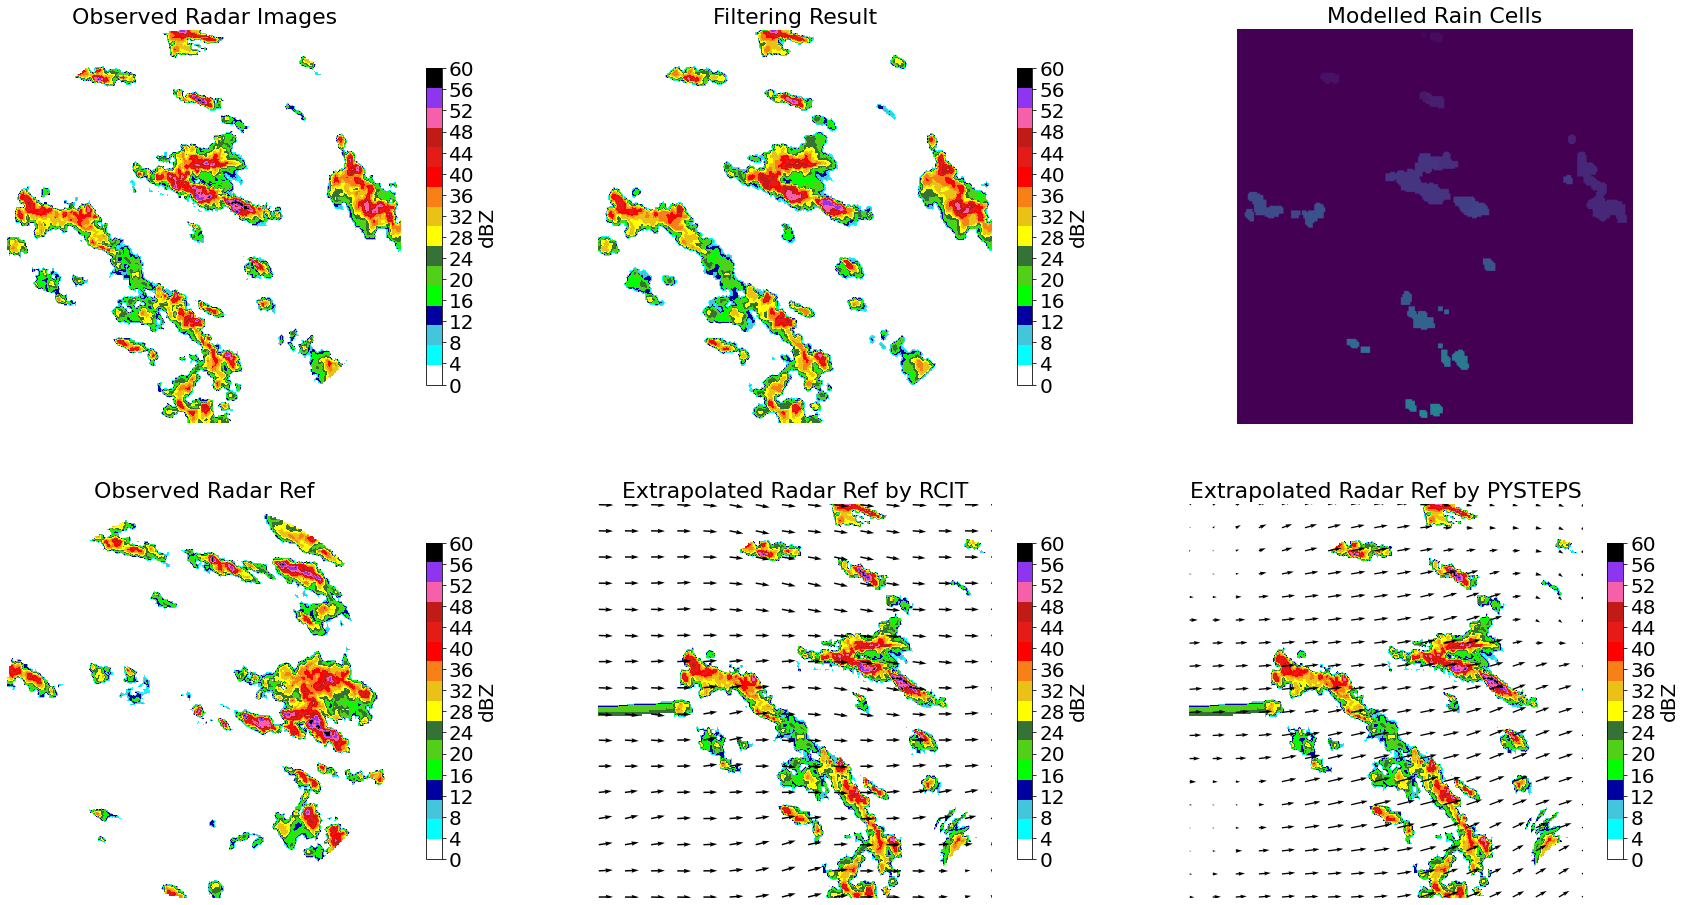

In [43]:
# Visulizing the results
outs = [radar_images[2], radar_images_filtered[2], labeled_rain_cells[2], radar_images[14], series_fcst_ref_rcit[11, :, :], series_fcst_ref_pysteps[11, :, :]]
titles = ['Observed Radar Images', 'Filtering Result', 'Modelled Rain Cells', 'Observed Radar Ref', 'Extrapolated Radar Ref by RCIT', 'Extrapolated Radar Ref by PYSTEPS']

fig, ax = plt.subplots(2, 3, figsize=(30, 16))
ax = ax.flatten()

# for i in range(5):
#     im = ax[i].imshow(outs[i], cmap=colormap, vmin=0, vmax=60)
#     ax[i].axis('off')
#     ax[i].set_title(titles[i], fontsize=22)

im0 = ax[0].imshow(outs[0], cmap=colormap, vmin=0, vmax=60)
ax[0].axis('off')
ax[0].set_title(titles[0], fontsize=22)

im1 = ax[1].imshow(outs[1], cmap=colormap, vmin=0, vmax=60)
ax[1].axis('off')
ax[1].set_title(titles[1], fontsize=22)

im2 = ax[2].imshow(outs[2], vmin=0, vmax=60)
ax[2].axis('off')
ax[2].set_title(titles[2], fontsize=22)

im3 = ax[3].imshow(outs[3], cmap=colormap, vmin=0, vmax=60)
ax[3].axis('off')
ax[3].set_title(titles[3], fontsize=22)

im4 = ax[4].imshow(outs[4], cmap=colormap, vmin=0, vmax=60)
ax[4].axis('off')
ax[4].set_title(titles[4], fontsize=22)

im5 = ax[5].imshow(outs[4], cmap=colormap, vmin=0, vmax=60)
ax[5].axis('off')
ax[5].set_title(titles[5], fontsize=22)

pos_x = location_motion_RCIT[0]
pos_y = location_motion_RCIT[1]

v_x = np.transpose(motion_RCIT[1][0, :, :])
v_y = np.transpose(motion_RCIT[1][1, :, :])

ax[4].quiver(pos_x[::17, ::17], pos_y[::17, ::17], v_x[::16, ::16], v_y[::16, ::16],color='black')

ax[5] = vis.quiver(motion_PYSteps, step=15)

cb0 = plt.colorbar(im0, ax=ax[0], shrink=0.8)
cb0.set_label("dBZ", fontsize=20)
cb0.ax.tick_params(labelsize=20)
cb0.set_ticks(np.linspace(0, 60, 16))

cb1 = plt.colorbar(im1, ax=ax[1], shrink=0.8)
cb1.set_label("dBZ", fontsize=20)
cb1.ax.tick_params(labelsize=20)
cb1.set_ticks(np.linspace(0, 60, 16))

cb3 = plt.colorbar(im3, ax=ax[3], shrink=0.8)
cb3.set_label("dBZ", fontsize=20)
cb3.ax.tick_params(labelsize=20)
cb3.set_ticks(np.linspace(0, 60, 16))

cb4 = plt.colorbar(im4, ax=ax[4], shrink=0.8)
cb4.set_label("dBZ", fontsize=20)
cb4.ax.tick_params(labelsize=20)
cb4.set_ticks(np.linspace(0, 60, 16))

cb5 = plt.colorbar(im4, ax=ax[5], shrink=0.8)
cb5.set_label("dBZ", fontsize=20)
cb5.ax.tick_params(labelsize=20)
cb5.set_ticks(np.linspace(0, 60, 16))

plt.show()